## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown --id 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 133MB/s]


## 1. Import libraries

In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

/home/aivn12s1/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Extract Data from XML and Store in New Folder

### Extract

In [2]:
def extract_data_from_xml(root_dir):
    """
    Trích xuất dữ liệu từ file words.xml trong bộ IC03
    
    Hàm này dùng để trích các thông tin từ file .xml bao gồm: 
    image paths, image sizes, image labels và bboxes 
    
    Parameters:
        root_dir (str): Đường dẫn đến thư mục root của dataset
    
    Returns:
        tuple: Chứa 4 lists lần lượt là: image paths, image sizes, image labels, và bboxes.
    """
    
    # Tạo path đến file words.xml 
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai báo các list rỗng để lưu dữ liệu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyệt qua từng thẻ ảnh <image>
    for img in root:
        # Khai báo các list rỗng chứa bboxes và labels của ảnh đang xét
        bbs_of_img = []
        labels_of_img = []

        # Duyệt qua từng thẻ boundingbox 
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bỏ qua trường hợp label không phải kí tự alphabet hoặc number
                if not bb[0].text.isalnum():
                    continue
                    
                # Bỏ qua trường hợp label là chữ 'é' hoặc ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Đưa thông tin tọa độ bbox vào list bbs_of_img
                # Format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']), 
                        float(bb.attrib['y']), 
                        float(bb.attrib['width']), 
                        float(bb.attrib['height'])
                    ]
                )
                # Đưa label vào list labels_of_img (đã chuyển chữ viết thường)
                labels_of_img.append(bb[0].text.lower())
                
        # Đưa thông tin path ảnh đang xét vào list img_paths
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Đưa thông tin độ phân giải ảnh vào list img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Đưa list bbox vào list bboxes
        bboxes.append(bbs_of_img)
        # Đưa list labels vào list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [3]:
# Thực hiện lời gọi hàm extract_data_from_xml()
dataset_dir = 'datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [4]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


### Plot an example

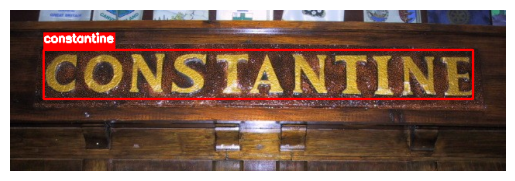

In [5]:
def plot_image_with_bbs(img_path, bbs, labels):
    """
    Trực quan hóa bounding box với label lên ảnh.
    
    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        bbs (list): Danh sách các bounding box.
        labels (list): Danh sách các label.
    """
    # Đọc ảnh
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    # Duyệt qua từng bounding box 
    for idx, bb in enumerate(bbs):
        # Vẽ bounding box lên ảnh
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)  
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Vẽ label lên cạnh bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)  
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)

        
        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


        cv2.putText(
            img, 
            label, 
            (int(bb[0]), int(bb[1] - 10)), 
            font, 
            font_scale, 
            font_color, 
            text_thickness, 
            line_type
        )

    # Show ảnh
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Random chỉ mục của một ảnh bất kỳ để visualize
i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

### Store all bounding boxes as a new dataset

In [6]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu cho Text Recognition.
    
    Hàm sẽ tạo một thư mục save_dir, lưu các ảnh cắt từ tọa độ bbox.
    Label sẽ được lưu riêng vào file labels.txt. 
    
    Parameters:
        img_paths (list): Danh sách các path ảnh.
        img_labels (list): Danh sách chứa danh sách labels của các ảnh.
        bboxes (list): Danh sách chứa danh sách bounding box của các ảnh.
        save_dir (str): Đường dẫn đến thư mục chứa dữ liệu.
    """
    # Tạo tự động thư mục chứa dữ liệu
    os.makedirs(save_dir, exist_ok=True)

    # Khai báo biến đếm và danh sách rỗng chứa labels
    count = 0
    labels = []  

    # Duyệt qua từng cặp (đường dẫn ảnh, list label, list bbox)
    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        # Đọc ảnh
        img = Image.open(img_path)

        # Duyệt qua từng cặp label và bbox
        for label, bb in zip(img_label, bbs):
            # Cắt ảnh theo bbox
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Bỏ qua trường hợp 90% nội dung ảnh cắt là màu trắng hoặc đen.
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue
                
            # Bỏ qua trường hợp ảnh cắt có width < 10 hoặc heigh < 10
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue
                
            # Bỏ qua trường hợp số kí tự của label < 3
            if len(label) < 3:
                continue

            # Tạo tên cho file ảnh đã cắt và lưu vào save_dir
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            # Đưa format label mới vào list labels
            # Format: img_path\tlabel
            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Đưa list labels vào file labels.txt
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

In [7]:
# Thực hiện lời gọi hàm split_bounding_boxes()
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 928 images


## 3. Read dataset

In [8]:
# Đọc dữ liệu từ thư mục đã tạo
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 928


## 4. Prepare vocabulary

In [9]:
# Lấy tất cả các kí tự trong danh sách labels 
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
# Lọc kí tự trùng
letters = sorted(list(set(list(letters))))

# Chuyển list kí tự thành string
chars = "".join(letters)
                
# Thêm kí tự "blank" vào bộ vocab
blank_char = '-'
chars += blank_char
# Tính vocab size
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [10]:
# Tạo dictionary chuyển đổi kí tự (class) sang dạng số và ngược lại 
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [11]:
# Tìm label có độ dài lớn nhất
# Đặt làm max_label_len để padding
max_label_len = max([len(label) for label in labels])

In [12]:
def encode(label, char_to_idx, max_label_len):
    """
    Encode label thành tensor
    
    Paramaters:
        label (str): String label. 
        char_to_idx (dict): Bảng mapping classname -> ID.
        max_label_len (int): Độ dài tối đa cho label.
        
    Returns:
        padded_labels (tensor): Tensor label đã được encode và padding.
        lengths (tensor): Độ dài trước khi padding của label.
    """
    # Đổi sang tensor 
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], 
        dtype=torch.long
    )
    # Tính len của label 
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len, 
        dtype=torch.long
    )
    # Padding 
    padded_labels = F.pad(
        encoded_labels, 
        (0, max_label_len - label_len), 
        value=0
    )
    
    return padded_labels, lengths

In [13]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded label thành string
    
    Parameters:
        encoded_sequences (list): Danh sách các tensor label.
        idx_to_char (dict): Bảng mapping ID -> classname.
        blank_char (str): Kí tự "blank".
        
    Returns:
        decoded_sequences (list): danh sách các label đã được decode.
    """
    # Khai báo list rỗng chứa kết quả decode 
    decoded_sequences = []

    # Duyệt qua từng encoded label 
    for seq in encoded_sequences:
        # Khai báo list rỗng chứa từng kí tự đã decode
        decoded_label = []
        # Duyệt qua từng token 
        for idx, token in enumerate(seq):
            # Bỏ qua token padding (ID=0)
            if token != 0:
                # Lấy kí tự của token đang xét trong idx_to_char
                char = idx_to_char[token.item()]
                # Bỏ qua kí tự "blank"
                if char != blank_char:
                    decoded_label.append(char)
        # Thêm chuỗi đã decode vào list decoded_sequences
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

## 5. Create data preprocessing function

In [14]:
# Khai báo hàm transform dữ liệu
data_transforms = {
    # Dành cho dữ liệu train 
    'train': transforms.Compose([
        transforms.Resize((32, 100)), 
        transforms.ColorJitter( 
            brightness=0.5, 
            contrast=0.5, 
            saturation=0.5
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=2, shear=2),  
        transforms.RandomPerspective(
            distortion_scale=0.4, 
            p=0.5, 
            interpolation=3
        ),  
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),  
        transforms.Normalize((0.5,), (0.5,)), 
    ]),
    # Dành cho dữ liệu val, test
    'val': transforms.Compose([
        transforms.Resize((32, 100)), 
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),  
        transforms.Normalize((0.5,), (0.5,)), 
    ]),
}

## 6. Train, val, test split

In [15]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## 7. Create pytorch dataset

In [16]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
            
        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, 
                self.char_to_idx, 
                self.max_label_len
            )
        return img, encoded_label, label_len

## 8. Create dataloader

In [17]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [18]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 649
Val dataset: 186
Test dataset: 93


In [34]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['home', 'rayleigh', 'you', 'beardwell', 'orange', 'conditions', 'estate', 'frank', 'july', '544444', 'year', 'national', 'inspiron', 'hoffman', 'private', 'updates', 'united', 'peter', 'raf', 'ipswich', 'sommerville', 'tested', 'emmerich', 'footpath', 'the', 'the', 'monument', 'royal', 'computing', '2002', 'maintenance', 'order', 'sack', 'gallery', 'keep', 'the', 'light', '1996', 'extra', 'research', 'conviction', 'heart', 'alligator', 'height', 'refill', 'wroxcom', 'can', 'lion', 'cigarettes', 'data', 'free', 'xml', 'dollar', 'extinguisher', 'directory', 'need', 'edition', 'harwich', 'lager', 'winter', 'nhs', 'wines', 'galvin', 'leisure', 'listerine', 'volvo', 'bequet', 'weather', 'ltd', 'airshow', 'strategy', 'centre', 'pleaes', 'v10', 'aircraft', 'exit', 'order', 'inhabited', 'inspiring', 'good', 'intelligent', 'let', 'fire', 'raised', 'the', 'heart', 'car', 'campbell', 'private', 'falling', 'support', 'from', 'silberschatz', 'dell', 'seatrade', 'club', 'the', 'support', 'wallace',

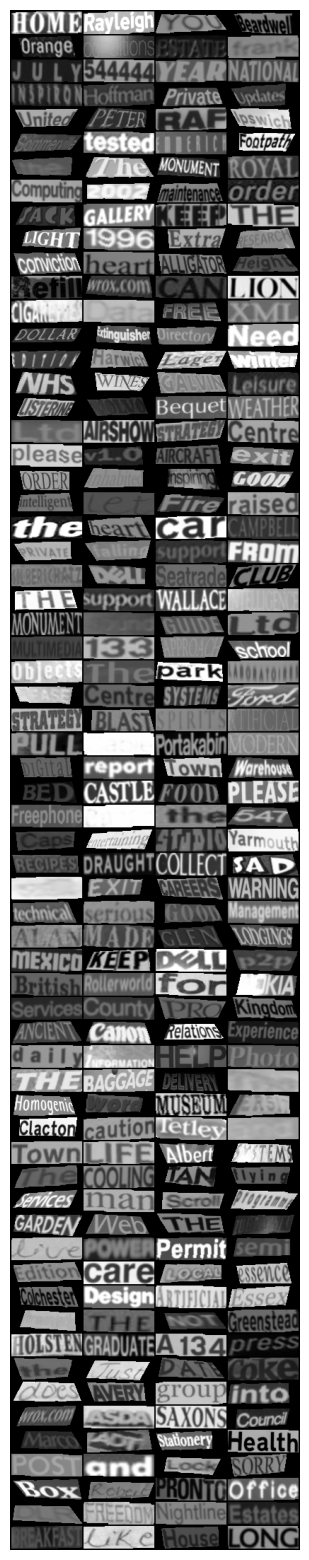

In [35]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True) 
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

## 9. Create model
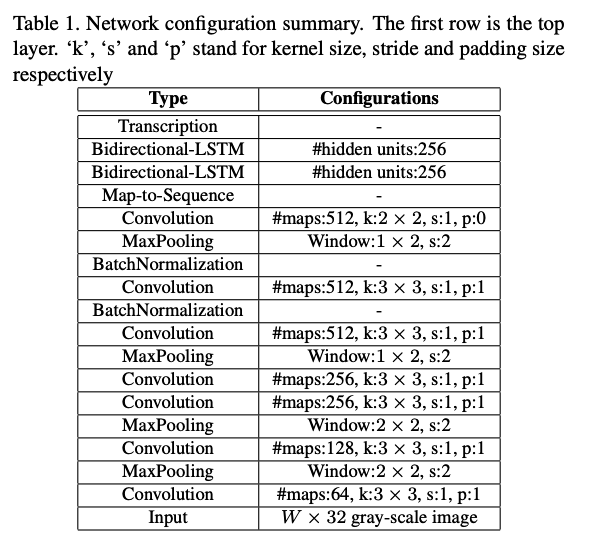

In [62]:
class CRNN(nn.Module):
    def __init__(
        self, 
        in_channels,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2
    ):
        super(CRNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        ) 

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        
        self.mapSeq = nn.Linear(512, 64)
        
        self.lstm = nn.LSTM(
            64, hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        #self.dropout = nn.Dropout(dropout)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),  
            nn.LogSoftmax(dim=2) 
        )
                                  
                                  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)         
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)  
        batch, channel, height, width = x.size()
        x = x.view(batch, channel * height, width)
        x = x.permute(2, 0, 1)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        #x = self.dropout(x)
        x = self.out(x)
        
        return x 

In [69]:
in_channels = 1
hidden_size = 256
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    in_channels=in_channels,
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob
).to(device)

In [70]:
model.eval()

dummy_tensor = torch.rand((64, 1, 32, 100)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([26, 64, 37])


## 10. Training

In [71]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)
            
            outputs = model(inputs)
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)
            
            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [72]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler, 
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)
            
            loss = criterion(outputs, labels, logits_lens, labels_len)            
            loss.backward()
            # Thực hiện gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), 
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())
            
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')
        
        scheduler.step()

    return train_losses, val_losses

In [73]:
epochs = 500
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.8

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char], 
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=lr, 
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=0.1
)

In [74]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 11.9443	Val loss: 11.8403
EPOCH 2:	Train loss: 4.1297	Val loss: 3.9099
EPOCH 3:	Train loss: 3.6268	Val loss: 3.7144
EPOCH 4:	Train loss: 3.5641	Val loss: 3.5024
EPOCH 5:	Train loss: 3.4185	Val loss: 3.5540
EPOCH 6:	Train loss: 3.4588	Val loss: 3.4957
EPOCH 7:	Train loss: 3.4087	Val loss: 3.5299
EPOCH 8:	Train loss: 3.4166	Val loss: 3.4686
EPOCH 9:	Train loss: 3.4043	Val loss: 3.4771
EPOCH 10:	Train loss: 3.3943	Val loss: 3.4582
EPOCH 11:	Train loss: 3.3811	Val loss: 3.4763
EPOCH 12:	Train loss: 3.3818	Val loss: 3.4562
EPOCH 13:	Train loss: 3.3850	Val loss: 3.4583
EPOCH 14:	Train loss: 3.3740	Val loss: 3.4547
EPOCH 15:	Train loss: 3.3690	Val loss: 3.4502
EPOCH 16:	Train loss: 3.3549	Val loss: 3.4368
EPOCH 17:	Train loss: 3.3484	Val loss: 3.4314
EPOCH 18:	Train loss: 3.3585	Val loss: 3.4425
EPOCH 19:	Train loss: 3.3745	Val loss: 3.4469
EPOCH 20:	Train loss: 3.3632	Val loss: 3.4293
EPOCH 21:	Train loss: 3.3582	Val loss: 3.4271
EPOCH 22:	Train loss: 3.3460	Val loss: 3.

EPOCH 178:	Train loss: 2.9800	Val loss: 3.1333
EPOCH 179:	Train loss: 2.9779	Val loss: 3.1244
EPOCH 180:	Train loss: 2.9644	Val loss: 3.1015
EPOCH 181:	Train loss: 2.9799	Val loss: 3.1134
EPOCH 182:	Train loss: 2.9877	Val loss: 3.1107
EPOCH 183:	Train loss: 2.9649	Val loss: 3.0934
EPOCH 184:	Train loss: 2.9784	Val loss: 3.1102
EPOCH 185:	Train loss: 2.9595	Val loss: 3.1317
EPOCH 186:	Train loss: 2.9797	Val loss: 3.1243
EPOCH 187:	Train loss: 2.9744	Val loss: 3.1103
EPOCH 188:	Train loss: 2.9978	Val loss: 3.1511
EPOCH 189:	Train loss: 3.0012	Val loss: 3.1493
EPOCH 190:	Train loss: 3.0032	Val loss: 3.1453
EPOCH 191:	Train loss: 2.9724	Val loss: 3.1322
EPOCH 192:	Train loss: 2.9523	Val loss: 3.1990
EPOCH 193:	Train loss: 2.9563	Val loss: 3.1461
EPOCH 194:	Train loss: 2.9615	Val loss: 3.1084
EPOCH 195:	Train loss: 2.9527	Val loss: 3.1123
EPOCH 196:	Train loss: 2.9589	Val loss: 3.1217
EPOCH 197:	Train loss: 2.9402	Val loss: 3.1256
EPOCH 198:	Train loss: 2.9671	Val loss: 3.1321
EPOCH 199:	Tr

EPOCH 353:	Train loss: 1.8709	Val loss: 2.7810
EPOCH 354:	Train loss: 1.7971	Val loss: 2.7303
EPOCH 355:	Train loss: 1.8600	Val loss: 2.7464
EPOCH 356:	Train loss: 1.8244	Val loss: 2.7243
EPOCH 357:	Train loss: 1.8663	Val loss: 2.7733
EPOCH 358:	Train loss: 1.8237	Val loss: 2.7549
EPOCH 359:	Train loss: 1.8893	Val loss: 2.7832
EPOCH 360:	Train loss: 1.8085	Val loss: 2.7433
EPOCH 361:	Train loss: 1.8241	Val loss: 2.7721
EPOCH 362:	Train loss: 1.8018	Val loss: 2.7935
EPOCH 363:	Train loss: 1.7624	Val loss: 2.7736
EPOCH 364:	Train loss: 1.7520	Val loss: 2.7221
EPOCH 365:	Train loss: 1.7168	Val loss: 2.7123
EPOCH 366:	Train loss: 1.7351	Val loss: 2.6955
EPOCH 367:	Train loss: 1.6944	Val loss: 2.7773
EPOCH 368:	Train loss: 1.6841	Val loss: 2.7107
EPOCH 369:	Train loss: 1.6339	Val loss: 2.7659
EPOCH 370:	Train loss: 1.6378	Val loss: 2.7253
EPOCH 371:	Train loss: 1.6622	Val loss: 2.6845
EPOCH 372:	Train loss: 1.6082	Val loss: 2.7832
EPOCH 373:	Train loss: 1.7626	Val loss: 2.7598
EPOCH 374:	Tr

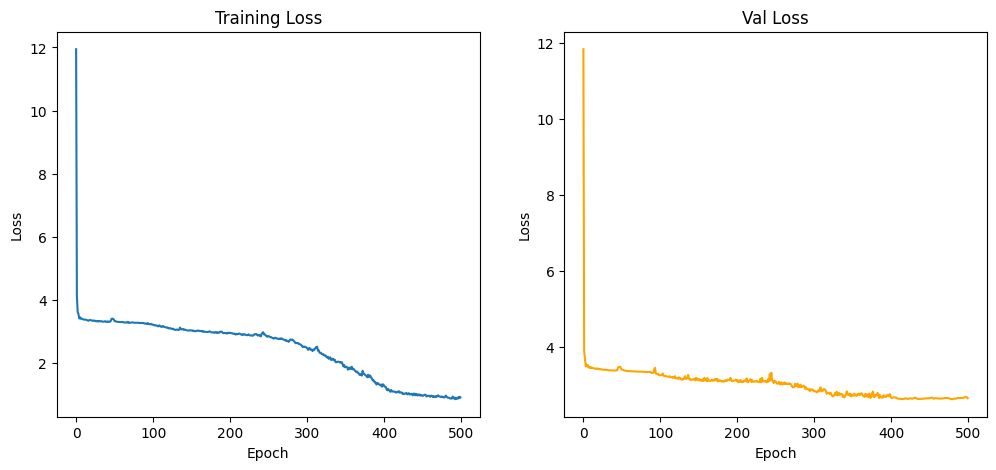

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 11. Evaluation

In [76]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  2.6623746951421103
Test loss:  2.8439142306645713


## 12. Make Predictions

In [77]:
def predict(model, img):
    model.val()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

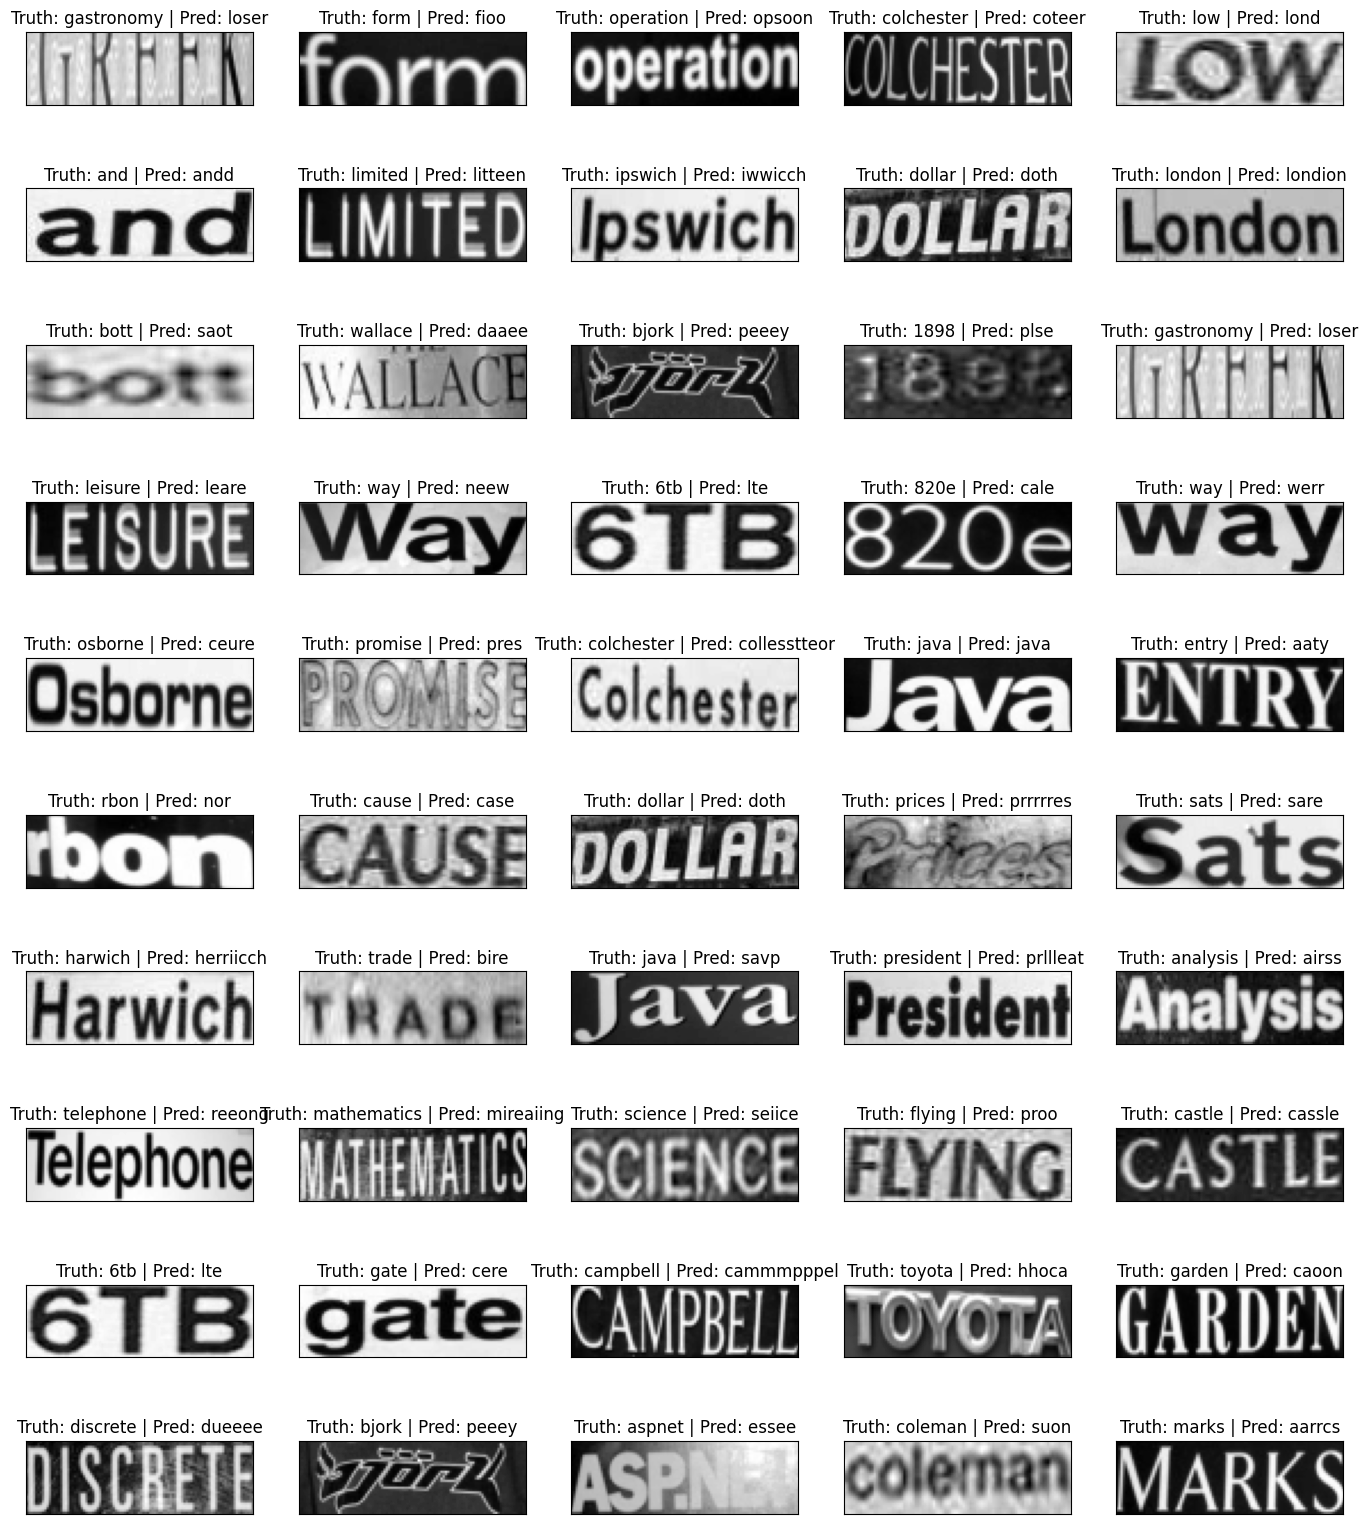

In [78]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))
    
    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

### Test dataset

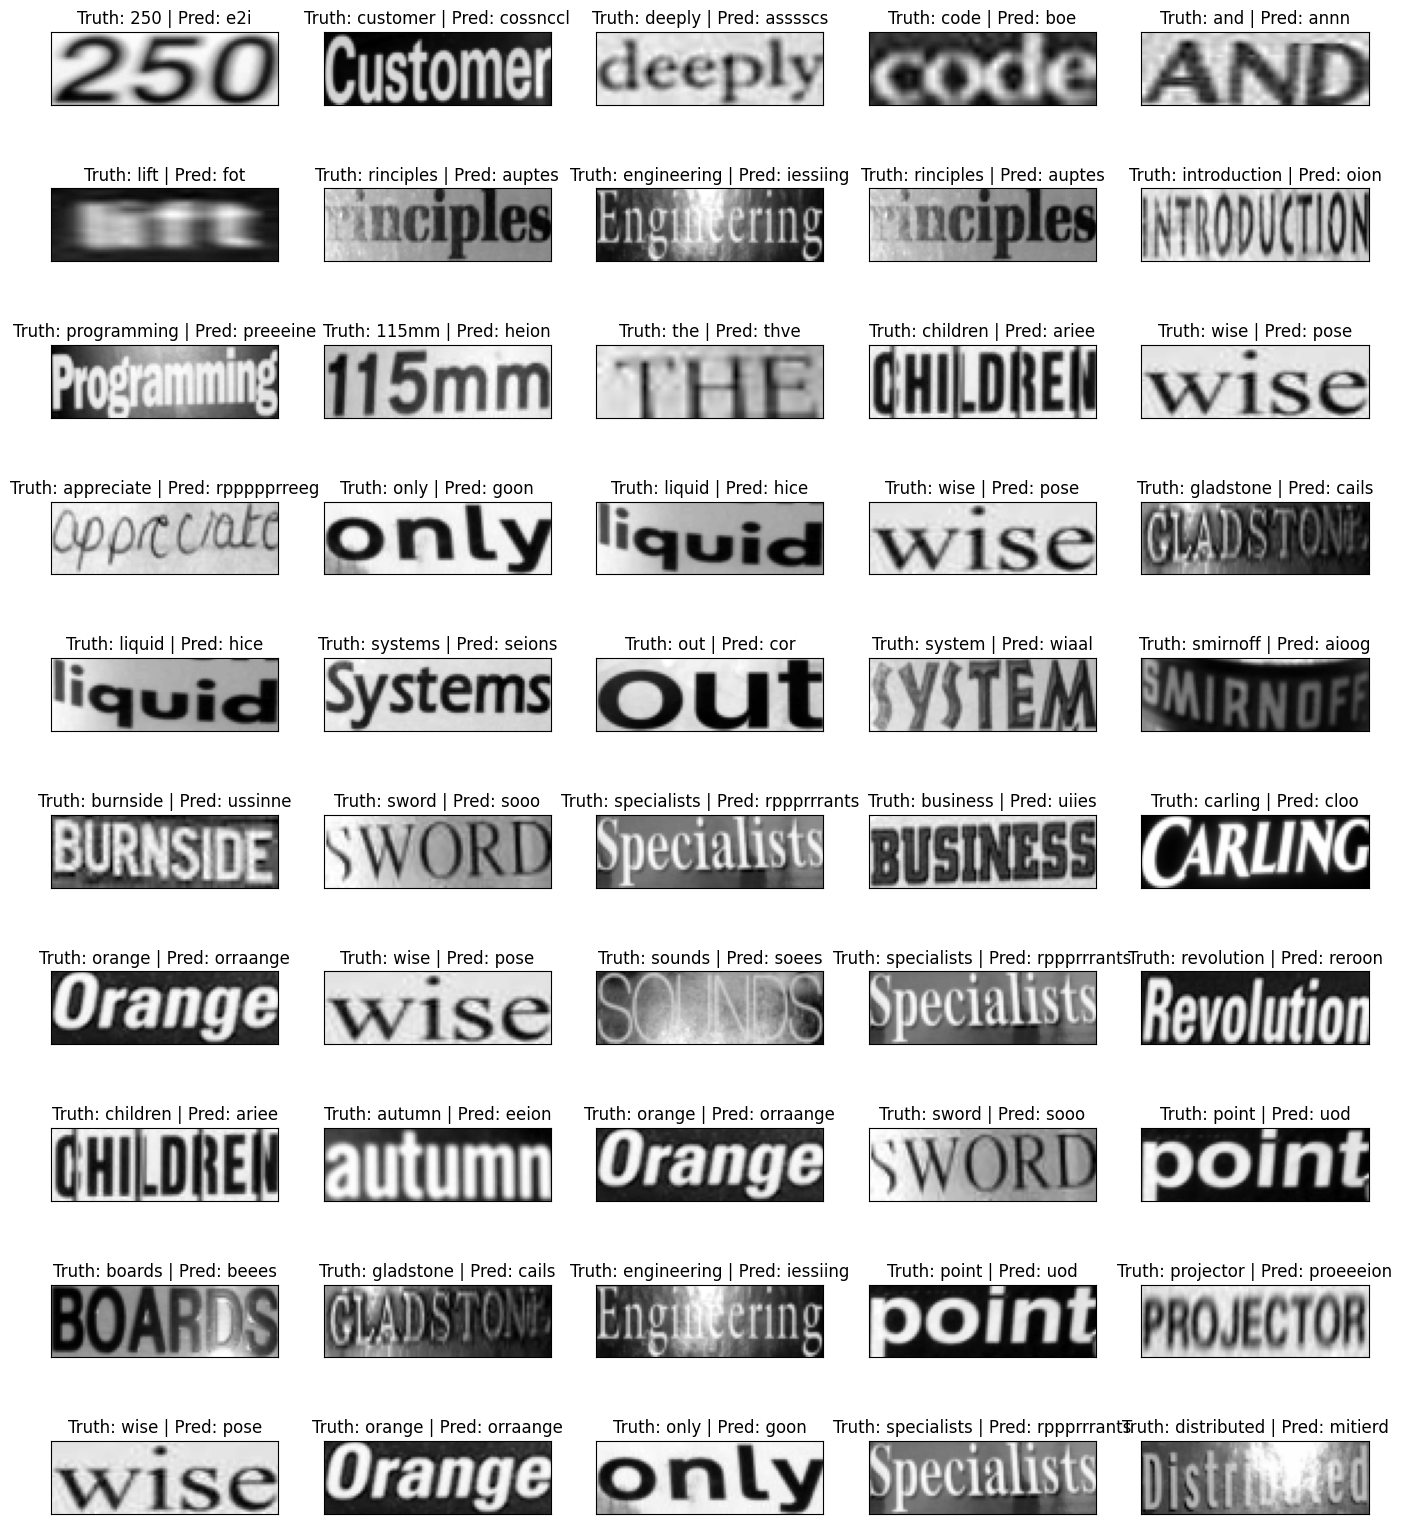

In [79]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))
    
    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

## 13. Save model

In [80]:
save_model_path = 'models/ocr_crnn_plain_best.pt'
torch.save(
    model.state_dict(), 
    save_model_path
)